In [1]:
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
record = "08455"

In [3]:
dataset_dir = "dataset/AFDB record_%s/" % record

csv_filenames = []
for filename in os.listdir(dataset_dir) :
    if filename.find(".csv") > -1:
        csv_filenames.append(filename)

In [4]:
file = open(dataset_dir + 'annotation.txt',"r") 
annotations = file.readlines()
file.close()

In [5]:
label_idx = []
for item in annotations[1:] :
    item_split = item.split()
    label_idx.append([item_split[0].replace("[", "").replace("]", ""), item_split[-1].replace("(", "")])

In [6]:
label_idx

[['03:07:13.584', 'AFIB'], ['03:08:02.972', 'N'], ['03:10:01.404', 'AFIB']]

In [7]:
def read_csv_to_df(filename, folder, sep=";"):
    df = pd.read_csv(folder + filename, sep=sep)
    print("[INFO] finish read file - %s" % filename)
    
    #df = df.drop(0) 
    df.columns = ['Time', 'ECG1', 'ECG2']

    df['ECG1'] = pd.to_numeric(df['ECG1'])
    df['ECG2'] = pd.to_numeric(df['ECG2'])
    
    # peak reduction
    df[df['ECG1'] > 2] = 2
    df[df['ECG1'] < -2] = -2
    df[df['ECG2'] > 2] = 2
    df[df['ECG2'] < -2] = -2
    print("[INFO] finish data cleansing - %s" % filename)

    df["Time"] = df['Time'].str.replace("[", "")
    df["Time"] = df['Time'].str.replace("]", "")
    df["Time"] = df['Time'].str.replace("'", "")

    df["Time"] = pd.to_datetime(df["Time"], errors='coerce')
    print("[INFO] finish time cleansing -  %s" % filename)
    
    df.set_index("Time", inplace=True)
    return df

In [8]:
list_df_ecg = []
for name in csv_filenames:
    df = read_csv_to_df(name, dataset_dir)
    list_df_ecg.append(df)
    
df_ecg = pd.concat(list_df_ecg)

[INFO] finish read file - DATA.csv
[INFO] finish data cleansing - DATA.csv
[INFO] finish time cleansing -  DATA.csv


In [9]:
df_ecg.head()

,ECG1,ECG2
Time,,
2021-08-12 03:05:00.000,-0.290,0.075
2021-08-12 03:05:00.004,-0.405,0.070
2021-08-12 03:05:00.008,-0.370,0.080
2021-08-12 03:05:00.012,-0.255,0.095
2021-08-12 03:05:00.016,-0.290,0.075


In [10]:
def plot_signal(data, fs, label="ECG sample raw data"):
    ecg1 = data['ECG1'].values
    ecg2 = data['ECG2'].values

    times = np.arange(data.shape[0], dtype='float') / fs
    
    plt.figure(figsize=(20, 10))
    plt.subplot(2, 1, 1)
    plt.plot(times, ecg1, '#1f77b4')
    plt.title(label)
    plt.xlabel("Time (s)")
    plt.ylabel('mV')
    plt.grid(True)
    plt.ylim([-2.1, 2.1])
    plt.legend(["channel 1"])
    
    plt.subplot(2, 1, 2)
    plt.plot(times, ecg2, '#ff7f0e')
    plt.xlabel("Time (s)")
    plt.ylabel('mV')
    plt.grid(True)
    plt.ylim([-2.1, 2.1])
    plt.legend(["channel 2"])
    
    plt.show()

In [11]:
fs = 250 #hz

03:05:00 03:05:06


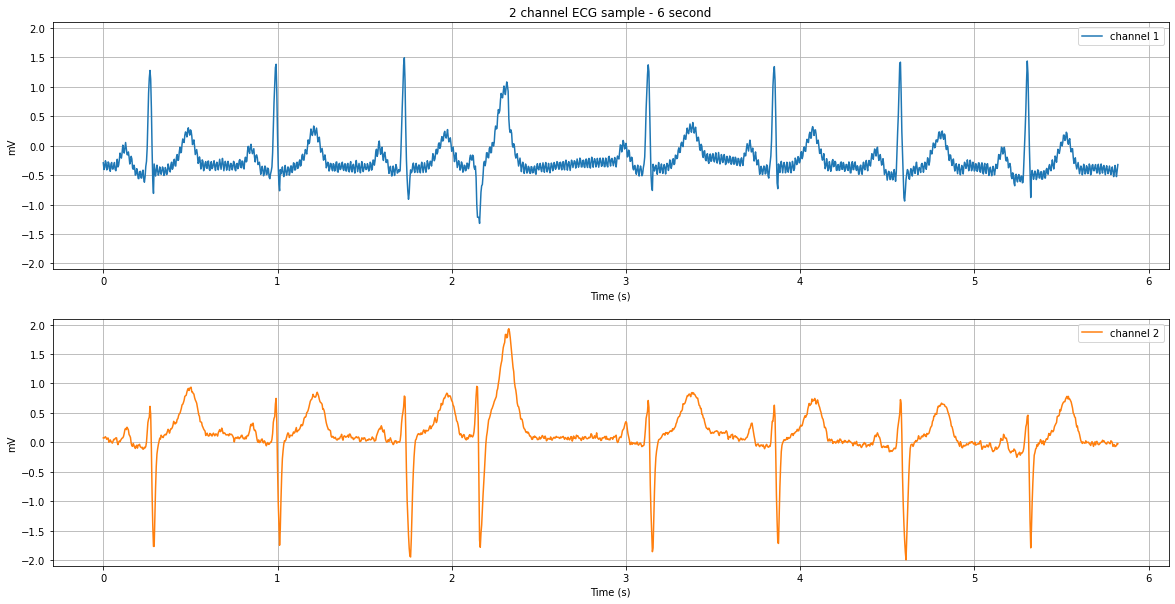

In [12]:
start = df_ecg.index[0].time()
end = (df_ecg.index[0] + datetime.timedelta(seconds=6)).time()
print(start, end)

plot_signal(df_ecg.between_time(start,end), fs, "2 channel ECG sample - 6 second")

In [13]:
label_idx

[['03:07:13.584', 'AFIB'], ['03:08:02.972', 'N'], ['03:10:01.404', 'AFIB']]

In [14]:
N_range = []
AFIB_range = []

for i in range(len(label_idx) - 1):
    tm_str = label_idx[i][0]
    next_tm_str = label_idx[i + 1][0]
    tm = pd.to_datetime(tm_str)
    next_tm = pd.to_datetime(next_tm_str)
    
    if label_idx[i][1] == 'N' :
        N_range.append([tm, next_tm])
    else :
        AFIB_range.append([tm, next_tm])

In [15]:
AFIB_range

[[Timestamp('2021-08-12 03:07:13.584000'),
  Timestamp('2021-08-12 03:08:02.972000')]]

In [16]:
N = []
for nr in N_range :
    result = df_ecg.between_time(nr[0].time(), nr[1].time())
    N.append(result)

In [17]:
AFIB = []
for ar in AFIB_range :
    result = df_ecg.between_time(ar[0].time(), ar[1].time())
    AFIB.append(result)

In [18]:
if not os.path.exists("dataset_split_per_class"):
    os.mkdir("dataset_split_per_class")

In [19]:
N = []
for ix, nr in enumerate(N_range) :
    result = df_ecg.between_time(nr[0].time(), nr[1].time())
    result.to_csv("dataset_split_per_class/%s_%s_%s_%s.csv" % 
                  ('N', record, 'ECG1', ix))
    N.append(result)

In [20]:
AFIB = []
for ix, ar in enumerate(AFIB_range) :
    result = df_ecg.between_time(ar[0].time(), ar[1].time())
    result.to_csv("dataset_split_per_class/%s_%s_%s_%s.csv" % 
                  ('AF', record, 'ECG1', ix))
    AFIB.append(result)

In [21]:
from scipy import sparse
from scipy.sparse.linalg import spsolve
from datetime import timedelta

In [22]:
def plot_6s_sample(data, label="2 channel ECG plot - 6s sample", y_label = 'mV'):
    ecg1 = data[0]
    ecg2 = data[1]
    
    times = np.arange(ecg1.shape[0], dtype='float') / fs
    
    plt.figure(figsize=(20, 10))
    plt.subplot(2,1,1)
    plt.plot(times, ecg1, '#1f77b4')
    plt.title(label)
    plt.xlabel('Time (s)')
    plt.ylabel(y_label)
    plt.legend(["channel 2"])
    plt.grid(True)
    
    plt.subplot(2,1,2)
    plt.plot(times, ecg2, '#ff7f0e')
    plt.xlabel('Time (s)')
    plt.ylabel(y_label)
    plt.legend(["channel 2"])
    plt.grid(True)
    
    plt.show()

In [23]:
def baseline_als(y, lam=10000, p=0.05, n_iter=10):
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    w = np.ones(L)
    for i in range(n_iter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

In [24]:
def perdelta(start, end, delta):
    curr = start
    while curr < end:
        yield curr
        curr += delta

In [30]:
time_interval_N = []
for N_item in N:
    intr = [time_result for time_result in perdelta(N_item.index[0], N_item.index[-1], timedelta(seconds=6))]
    time_interval_N.append(intr)

In [31]:
time_interval_AFIB = []
for AFIB_item in AFIB:
    intr = [time_result for time_result in perdelta(AFIB_item.index[0], AFIB_item.index[-1], timedelta(seconds=6))]
    time_interval_AFIB.append(intr)

In [32]:
ECG_ALS = []
ECG_ALS_label = []

for time_interval in time_interval_N :
    for time_intv in list(zip(time_interval, time_interval[1:])):
        X = df_ecg.between_time(time_intv[0].time(), time_intv[1].time())
        ecg1 = X['ECG1'].values
        ecg2 = X['ECG2'].values
        
        if len(ecg1) > 0 and len(ecg2) > 0:
            ALS1 = ecg1 - baseline_als(ecg1)
            ALS2 = ecg2 - baseline_als(ecg2)

            ECG_ALS.append(np.array([ALS1, ALS2]))
            ECG_ALS_label.append('N')
        
for time_interval in time_interval_AFIB :
    for time_intv in list(zip(time_interval, time_interval[1:])):
        X = df_ecg.between_time(time_intv[0].time(), time_intv[1].time())
        ecg1 = X['ECG1'].values
        ecg2 = X['ECG2'].values
        
        if len(ecg1) > 0 and len(ecg2) > 0:
            ALS1 = ecg1 - baseline_als(ecg1)
            ALS2 = ecg2 - baseline_als(ecg2)

            ECG_ALS.append(np.array([ALS1, ALS2]))
            ECG_ALS_label.append('AF')

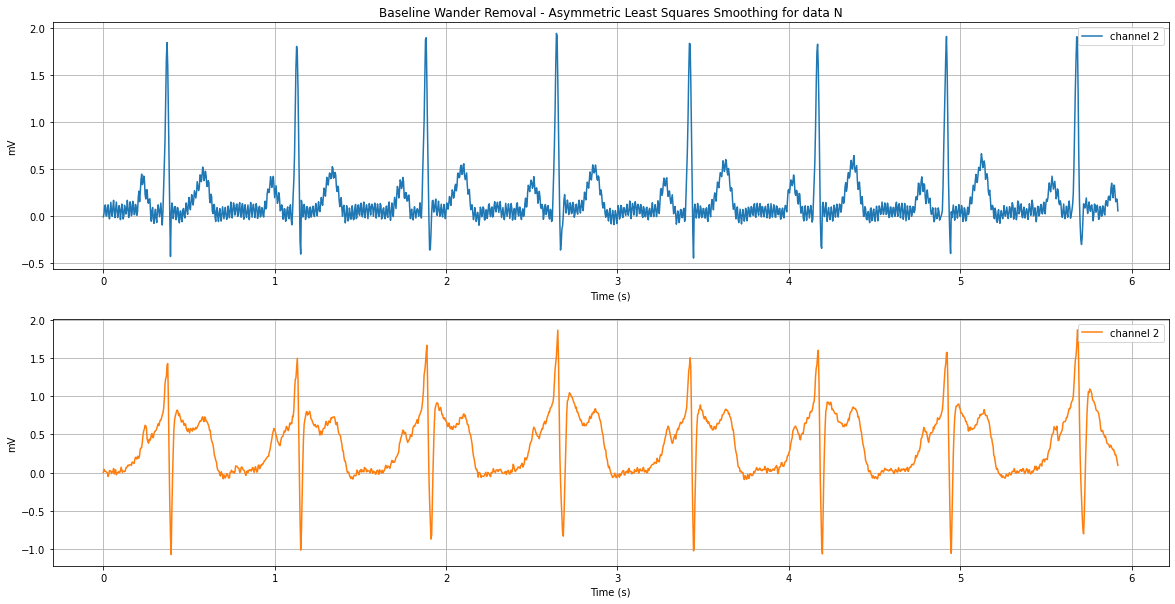

In [33]:
idx = 0
plot_6s_sample(ECG_ALS[idx], label="Baseline Wander Removal - Asymmetric Least Squares Smoothing for data %s" % ECG_ALS_label[idx])

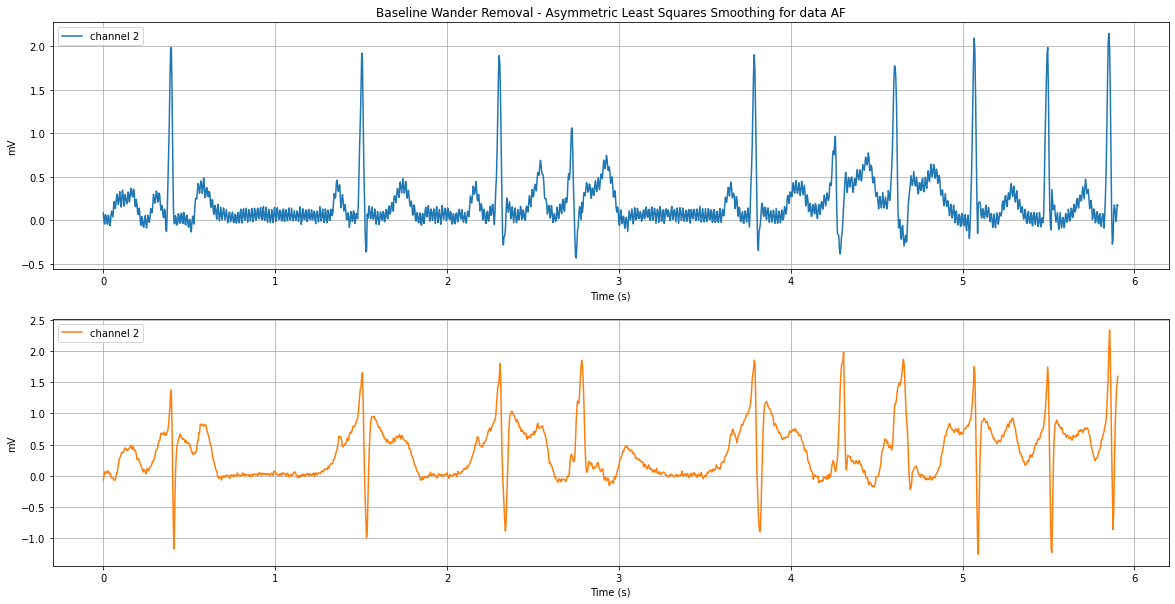

In [34]:
idx = -1
plot_6s_sample(ECG_ALS[idx], label="Baseline Wander Removal - Asymmetric Least Squares Smoothing for data %s" % ECG_ALS_label[idx])


In [35]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler

In [36]:
scaler = MaxAbsScaler()

ECG_ALS_Norm = []

for als in ECG_ALS :
    als1 = np.expand_dims(als[0], 1)
    als2 = np.expand_dims(als[1], 1)
    
    scaler.fit(als1)
    
    als_norm1 = scaler.transform(als1)
    als_norm2 = scaler.transform(als2)
    
    ECG_ALS_Norm.append([als_norm1, als_norm2])

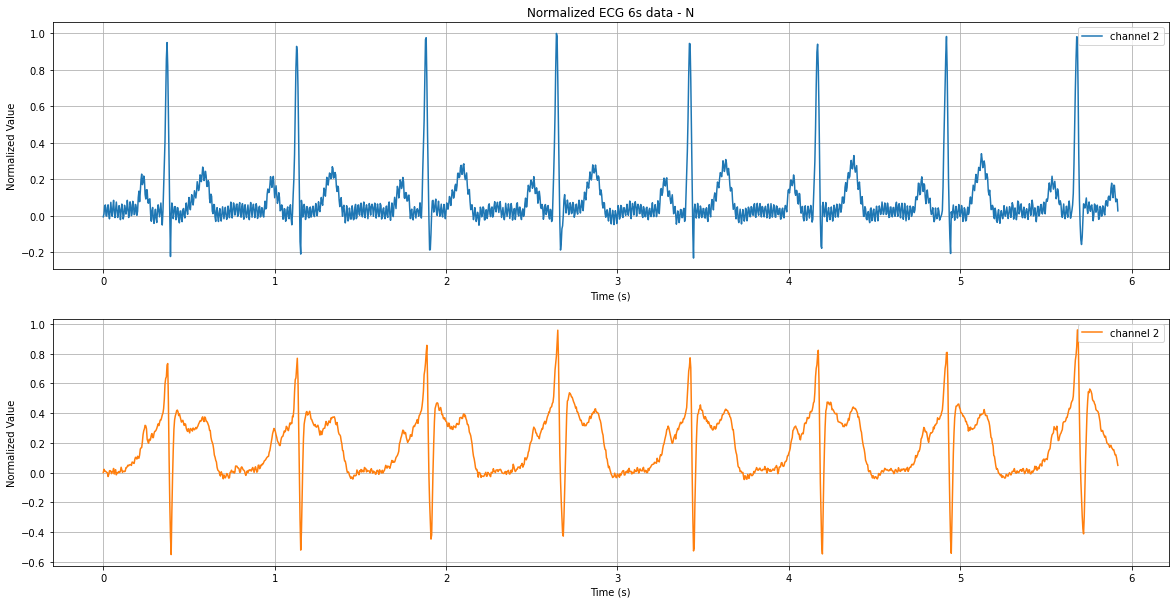

In [37]:
idx = 0
plot_6s_sample(ECG_ALS_Norm[idx], "Normalized ECG 6s data - %s" % ECG_ALS_label[idx], y_label = 'Normalized Value')

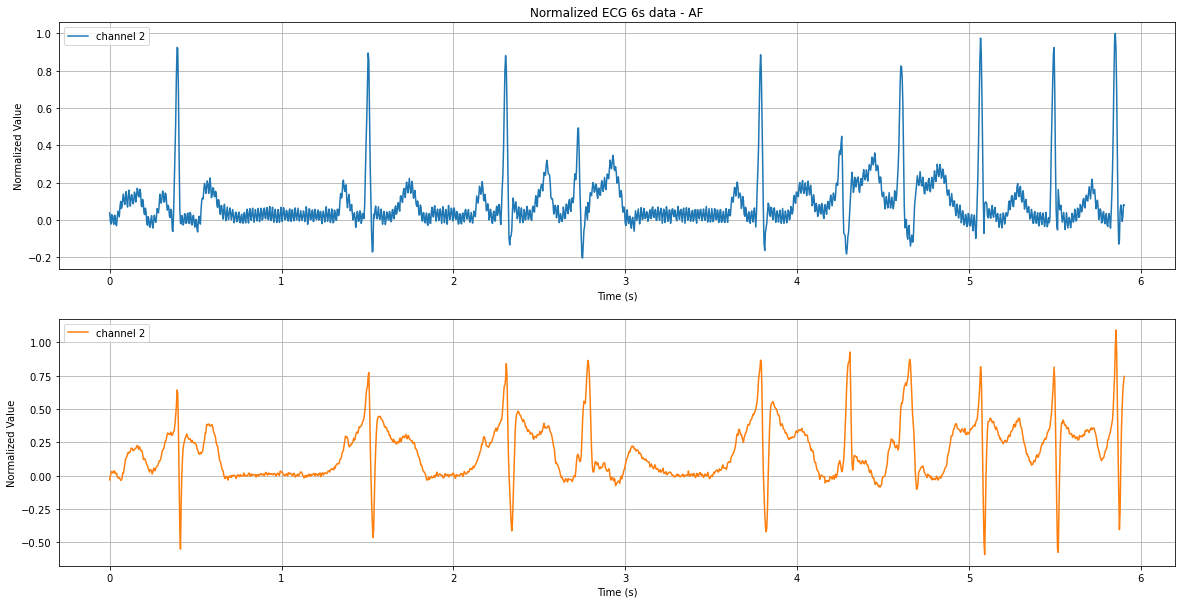

In [38]:
idx = -1
plot_6s_sample(ECG_ALS_Norm[idx], "Normalized ECG 6s data - %s" % ECG_ALS_label[idx], y_label = 'Normalized Value')

In [43]:
data = []
pad_size = 4000 # 16s x 250hz
for i in range(len(ECG_ALS_Norm)):
    signal_ch = []
    for ch in [0, 1] :
        signal = np.array(ECG_ALS_Norm[i])[ch, :, 0]
        n = len(signal) if len(signal) <= pad_size else pad_size
        pad = np.zeros(pad_size)
        pad[0:n] = signal[0:n] 
        signal_ch.extend(list(pad))    
    signal_ch.append(ECG_ALS_label[i])
    data.append(signal_ch)

In [44]:
ECG = pd.DataFrame(data)

In [45]:
ECG.head()

,0,1,2,3,4,5,6,7,8,9,...,7991,7992,7993,7994,7995,7996,7997,7998,7999,8000
0,-0.005051,0.010566,0.054506,0.059827,0.000781,-0.001621,0.044897,0.060520,0.006627,-0.016370,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,N
1,0.222672,0.177673,0.183482,0.196546,0.156377,0.101680,0.100197,0.110791,0.072971,0.003666,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,N
2,0.016857,0.095315,0.129376,0.106709,0.108704,0.162491,0.191608,0.154122,0.163485,0.182696,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,N
3,-0.020804,-0.048126,-0.024083,0.046439,0.043604,0.033456,0.055139,0.111107,0.130438,0.108246,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,N
4,0.064817,0.007147,-0.012273,0.021857,0.040687,-0.001683,-0.028751,0.023234,0.052273,0.007371,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,N


In [47]:
# save Signal Sequence 6s 

ECG.to_csv("dataset/AFDB_%s_sequence_6s_2_ch.csv" % record, index=False, header=False)